In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import numpy as np

import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

from datasets import Dataset, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
# from ydata_profiling import ProfileReport

2025-07-20 11:35:51.846013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753011352.211470      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753011352.318689      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
imbd_df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [5]:
# profile = ProfileReport(imbd_df, title="Profiling Report")
# profile

In [6]:
imbd_df.shape

(50000, 2)

In [7]:
imbd_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
imbd_df.columns

Index(['review', 'sentiment'], dtype='object')

In [9]:
imbd_df.duplicated().any()

True

In [10]:
imbd_df.duplicated().sum()

418

In [11]:
duplicated_df = imbd_df[imbd_df.duplicated(keep=False)]

In [12]:
grouped = duplicated_df.sort_values(by=list(imbd_df.columns)).reset_index()

In [13]:
grouped

,index,review,sentiment
0,34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
1,47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
2,29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
3,31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
4,2976,"""Witchery"" might just be the most incoherent a...",negative
...,...,...,...
819,47876,this movie sucks. did anyone notice that the e...,negative
820,23056,"well, the writing was very sloppy, the directi...",negative
821,44122,"well, the writing was very sloppy, the directi...",negative
822,10163,"when I first heard about this movie, I noticed...",positive


In [14]:
# print(imbd_df.loc[23056].review)
# print('\n\n')
# print(imbd_df.loc[44122].review)

In [15]:
imbd_df.drop_duplicates(inplace=True)

In [16]:
imbd_df['words per review'] = imbd_df['review'].str.split().apply(len)

In [17]:
imbd_df.head()

,review,sentiment,words per review
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


In [18]:
imbd_df.sort_values(by="words per review", ascending=False).head()

,review,sentiment,words per review
31481,Match 1: Tag Team Table Match Bubba Ray and Sp...,positive,2470
40521,There's a sign on The Lost Highway that says:<...,positive,2278
31436,"Back in the mid/late 80s, an OAV anime by titl...",positive,2125
31240,"(Some spoilers included:)<br /><br />Although,...",positive,2108
12647,Titanic directed by James Cameron presents a f...,positive,1839


In [19]:
imbd_df['words per review'].describe()

count    49582.000000
mean       231.350167
std        171.542020
min          4.000000
25%        126.000000
50%        173.000000
75%        281.000000
max       2470.000000
Name: words per review, dtype: float64

In [20]:
# imbd_df.loc[12647].review

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

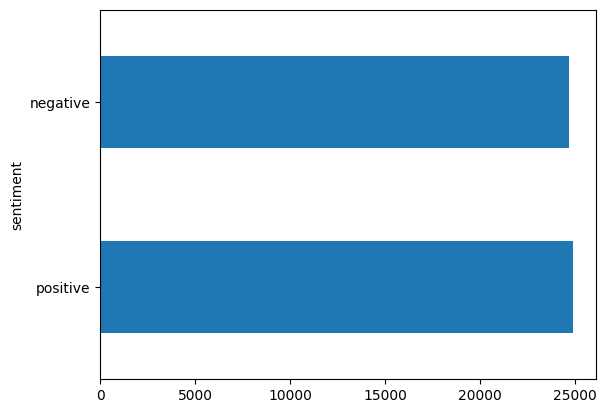

In [21]:
imbd_df['sentiment'].value_counts().plot.barh()
imbd_df['sentiment'].value_counts()

Text(0.5, 1.0, 'Comparision of length if riview w/e sentiment')

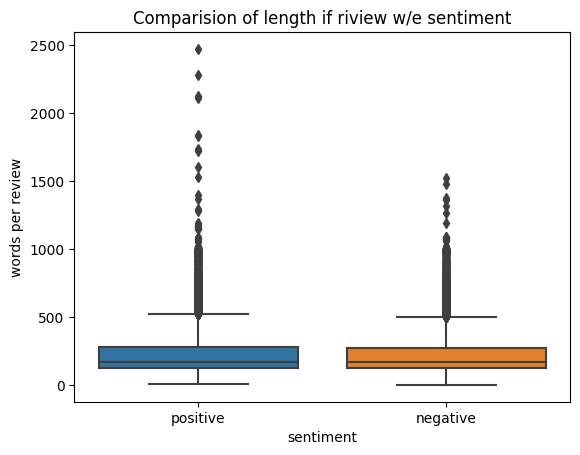

In [22]:
sns.boxplot(x='sentiment', y='words per review', data=imbd_df)
plt.title("Comparision of length if riview w/e sentiment")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


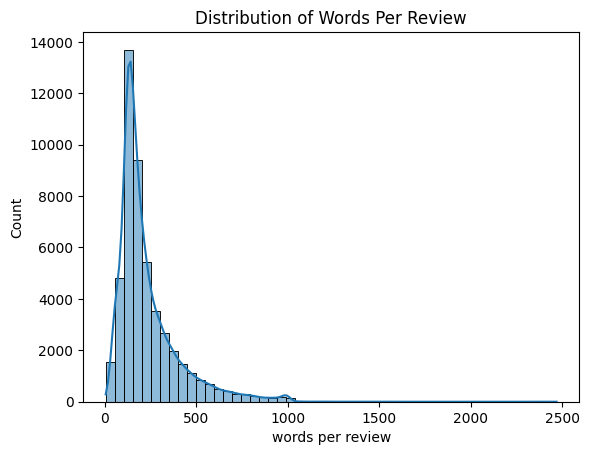

In [23]:
sns.histplot(imbd_df['words per review'], bins=50, kde=True)
plt.title("Distribution of Words Per Review")
plt.show()

<Axes: >

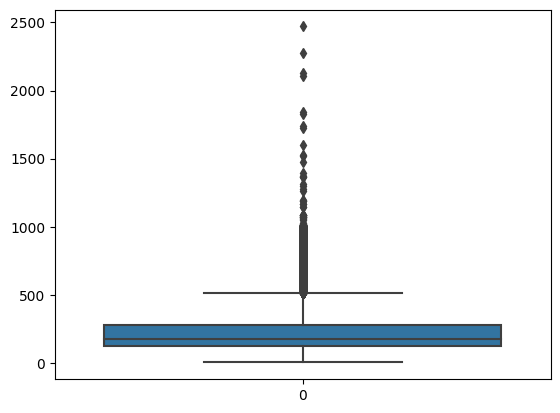

In [24]:
sns.boxplot(imbd_df['words per review'])

In [25]:
imbd_df.drop('words per review', axis=1, inplace=True)

In [26]:
imbd_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [27]:
# imbd_df['review'].str.extractall(r'(<[^>]+>)').value_counts()

In [28]:
# imbd_df['review'].str.extractall(r'([^\x00-\x7F])').value_counts()

In [29]:
imbd_df['review'] = imbd_df['review'].str.lower()

In [30]:
def cleaner(text):
  return re.sub(r"(?:<br\s*/?>|</?i>|[^\w\s'])", '', text)

In [31]:
imbd_df['review'] = imbd_df['review'].apply(cleaner)

In [32]:
imbd_df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,petter mattei's love in the time of money is a...,positive


In [33]:
imbd_df['review'].str.extractall(r'(<[^>]+>)').value_counts()

Series([], Name: count, dtype: int64)

In [34]:
# imbd_df['review'].str.extractall(r'([^\x00-\x7F])').value_counts()

In [35]:
def remove_accent(text):
  return ''.join(
      c for c in unicodedata.normalize('NFKD', text) if not unicodedata.combining(c)
  )

In [36]:
imbd_df['review'] = imbd_df['review'].apply(remove_accent)

In [37]:
# imbd_df['review'].str.extractall(r'([^\x00-\x7F])').value_counts()

In [38]:
replacement_map = {
    '⁄': '/',      # Fraction slash → normal slash
    'ø': 'o',      # Scandinavian letter → closest English sound
    'æ': 'ae',     # Latin ligature → common English substitute
    'ß': 'ss',     # German Eszett → "ss"
    'ð': 'd',      # Icelandic eth → "d"
    'þ': 'th',}    # Icelandic thorn → "th"

In [39]:
for old, new in replacement_map.items():
  imbd_df['review'] = imbd_df["review"].str.replace(old, new, regex=False)

In [40]:
# imbd_df['review'].str.extractall(r'([^\x00-\x7F])').value_counts()

In [41]:
non_ascii = imbd_df['review'].str.extractall(r'([^\x00-\x7F])')[0].value_counts().index.to_list()

In [42]:
non_ascii

['\x85', 'ı', 'י', 'ג', 'א', 'ל', 'כ', 'ר', 'מ', 'ו', 'ן']

In [43]:
for char in non_ascii:
  imbd_df["review"] = imbd_df["review"].str.replace(char, '', regex=False)

In [44]:
imbd_df['review'].str.extractall(r'([^\x00-\x7F])').value_counts()

Series([], Name: count, dtype: int64)

In [45]:
# imbd_df["review"][0].split()

In [46]:
def stopword_remover(text):
  return ' '.join([w for w in text.split() if w not in stop_words])

In [47]:
imbd_df["normalized_review"] = imbd_df["review"].apply(stopword_remover)

In [48]:
# imbd_df['review'][2]

In [49]:
# imbd_df['normalized_review'][2]

In [50]:
nlp = spacy.load('en_core_web_sm')

def lemmatize(text):
  return ' '.join([token.lemma_ for token in nlp(text)])

In [51]:
# imbd_df["normalized_review"] = imbd_df['normalized_review'].apply(lemmatize)

In [52]:
# imbd_df['review'][2]

In [53]:
# imbd_df['normalized_review'][2]

In [54]:
X = imbd_df['normalized_review']
y = imbd_df['sentiment']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [56]:
vectorizer = TfidfVectorizer(max_features=10_000, ngram_range=(1, 2), min_df=2, max_df=0.95)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [57]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [58]:
X_train.shape

(39665,)

In [59]:
X_train_vec.shape

(39665, 10000)

In [60]:
lr = LogisticRegression(max_iter=1000)

In [61]:
lr.fit(X_train_vec, y_train_enc)

LogisticRegression(max_iter=1000)

In [62]:
lr.score(X_test_vec, y_test_enc)

0.8906927498235353

In [63]:
def model_metrics(model, X_test, y_test):
  pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  conf_mat = confusion_matrix(y_test, pred)
  class_rep = classification_report(y_test, pred)

  print(f"Accuracy Score: {accuracy:.4f} | Precision Score: {precision:.4f} | Recall Score: {recall:.4f} | F1 Score: {f1:.4f} \n\n Confusion Matrix \n {conf_mat} \n\n Classification Report \n {class_rep}")

  # return {
  #       "accuracy": accuracy,
  #       "precision": precision,
  #       "recall": recall,
  #       "f1": f1,
  #       "confusion_matrix": conf_mat,
  #       "classification_report": class_rep
  #   }

In [64]:
model_metrics(lr, X_test_vec, y_test_enc)

Accuracy Score: 0.8907 | Precision Score: 0.8817 | Recall Score: 0.9034 | F1 Score: 0.8924 

 Confusion Matrix 
 [[4337  603]
 [ 481 4496]] 

 Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      4940
           1       0.88      0.90      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



In [65]:
lsvc = LinearSVC(max_iter=1000)

In [66]:
lsvc.fit(X_train_vec, y_train_enc)

LinearSVC()

In [67]:
lsvc.score(X_test_vec, y_test_enc)

0.8829283049309267

In [68]:
model_metrics(lsvc, X_test_vec, y_test_enc)

Accuracy Score: 0.8829 | Precision Score: 0.8799 | Recall Score: 0.8879 | F1 Score: 0.8839 

 Confusion Matrix 
 [[4337  603]
 [ 558 4419]] 

 Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.88      0.88      4940
           1       0.88      0.89      0.88      4977

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



In [69]:
mnb = MultinomialNB()

In [70]:
mnb.fit(X_train_vec, y_train_enc)

MultinomialNB()

In [71]:
mnb.score(X_test_vec, y_test_enc)

0.8663910456791368

In [72]:
model_metrics(mnb, X_test_vec, y_test_enc)

Accuracy Score: 0.8664 | Precision Score: 0.8569 | Recall Score: 0.8809 | F1 Score: 0.8687 

 Confusion Matrix 
 [[4208  732]
 [ 593 4384]] 

 Classification Report 
               precision    recall  f1-score   support

           0       0.88      0.85      0.86      4940
           1       0.86      0.88      0.87      4977

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



In [73]:
df = pd.read_csv("/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df['labels'] = df['sentiment'].map({"positive": 1, "negative": 0})
dataset = Dataset.from_pandas(df[["review", "labels"]])
dataset = dataset.train_test_split(test_size=0.2, seed=42)

In [74]:
def cleaner_(text):
  text = text.lower()
  text = re.sub(r"(?:<br\s*/?>|</?i>|[^\w\s'])", "", text)
  text = ''.join(c for c in unicodedata.normalize('NFKD', text) if not unicodedata.combining(c))
  for old, new in replacement_map.items():
    text = text.replace(old, new)
  return text
    
def cleaner_batch(batch):
    batch["review"] = [cleaner_(x) for x in batch["review"]]
    return batch

In [75]:
dataset = dataset.map(cleaner_batch, batched = True)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [76]:
# dataset["train"][:1]

In [77]:
# class_label = ClassLabel(names=["negative", "positive"])

In [78]:
# dataset = dataset.cast_column("sentiment", class_label)

In [79]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [80]:
def tokenizer_function(batch):
  return tokenizer(batch["review"], padding = "max_length", truncation=True, max_length=512)

In [81]:
tokenized_dataset = dataset.map(tokenizer_function, batched=True, remove_columns=["review"])
tokenized_dataset.set_format("torch")  # Important for Trainer to work efficiently

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [82]:
# tokenized_dataset = tokenized_dataset.rename_column("sentiment", "labels")

In [83]:
# tokenized_dataset["train"].features

In [84]:
# tokenized_dataset["test"].features

In [85]:
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
os.makedirs("/kaggle/working/bert_checkpoint/run_1", exist_ok="True")
os.makedirs("/kaggle/working/model/bert_run_1", exist_ok="True")

In [87]:
training_args = TrainingArguments(
    output_dir='/kaggle/working/bert_checkpoint/run_1',
    run_name= "bert_finetune_run_1",
    eval_strategy="epoch",
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 2,
    weight_decay = 0.01,
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
    disable_tqdm = False,
    fp16=True,
    logging_steps=100,
    report_to="none"
)

In [88]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
        "f1": f1_score(labels, predictions)
    }

In [89]:
trainer = Trainer(
    model = model,
    args=training_args,
    train_dataset = tokenized_dataset["train"],
    eval_dataset = tokenized_dataset["test"],
    compute_metrics = compute_metrics
)

In [90]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,0.184800,0.174562,0.936700,0.936439
2,0.120700,0.198973,0.939100,0.938960
3,0.237500,0.861019,0.932400,0.933373
4,0.148800,0.892948,0.938000,0.937298


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=5000, training_loss=0.1740501262664795, metrics={'train_runtime': 9298.1896, 'train_samples_per_second': 17.208, 'train_steps_per_second': 0.538, 'total_flos': 4.20977688576e+16, 'train_loss': 0.1740501262664795, 'epoch': 4.0})

In [ ]:

# After trainer.predict(...)
preds_output = trainer.predict(test_tokenized)
logits = preds_output.predictions
labels = preds_output.label_ids
predictions = np.argmax(logits, axis=1)

# Confusion matrix and classification report
print(confusion_matrix(labels, predictions))
print(classification_report(labels, predictions, target_names=["negative", "positive"]))

In [91]:
trainer.save_model("/kaggle/working/model/bert_run_1")


In [92]:
!zip -r ouput.zip '/kaggle/working/bert_checkpoint/run_1/checkpoint-1250'

  adding: kaggle/working/bert_checkpoint/run_1/checkpoint-1250/ (stored 0%)
  adding: kaggle/working/bert_checkpoint/run_1/checkpoint-1250/rng_state.pth (deflated 25%)
  adding: kaggle/working/bert_checkpoint/run_1/checkpoint-1250/optimizer.pt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 11%)
  adding: kaggle/working/bert_checkpoint/run_1/checkpoint-1250/training_args.bin (deflated 52%)
  adding: kaggle/working/bert_checkpoint/run_1/checkpoint-1250/model.safetensors (deflated 7%)
  adding: kaggle/working/bert_checkpoint/run_1/checkpoint-1250/scaler.pt (deflated 60%)
  adding: kaggle/working/bert_checkpoint/run_1/checkpoint-1250/config.json (deflated 49%)
  adding: kaggle/working/bert_checkpoint/run_1/checkpoint-1250/trainer_state.json (deflated 72%)
  adding: kaggle/working/bert_checkpoint/run_1/checkpoint-1250/scheduler.pt (deflated 55%)


In [93]:
!zip -r m_output.zip '/kaggle/working/model'

  adding: kaggle/working/model/ (stored 0%)
  adding: kaggle/working/model/bert_run_1/ (stored 0%)
  adding: kaggle/working/model/bert_run_1/training_args.bin (deflated 52%)
  adding: kaggle/working/model/bert_run_1/model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 7%)
  adding: kaggle/working/model/bert_run_1/config.json (deflated 49%)
